# Emotion Recognition in Speech - Data Wrangling

## Contents

* [Introduction](#Introduction)
    * [Data Science Problem](#Data_Science_Problem)
* [Imports](#Imports)
* [Objectives](#Objectives)
* [About the dataset](#About_the_dataset)
    * [Loading and Visualizing an Audio File](#Loading_and_Visualizing_an_Audio_File)
    * [Audio File information](#Audio_File_information)
    * [Playing a sample](#Playing_a_sample)
* [Vizualizing](#Vizualizing)
    * [Visualizing the Audio File](#Visualizing_the_Audio_File)
    * [Trimming the file](#Trimming_the_file)
    * [Spectrogram](#Spectrogram)
    * [Display in log-frequency](#Display_in_log-frequency)
    * [Down Sampling Test](#Down_Sampling_Test)
    * [MFCC, Chroma, Mel Test](#MFCC,_Chroma,_Mel_Test)
* [Creating a dataframe](#Creating_a_dataframe)
* [Exploring the dataframe](#Exploring_the_dataframe)
    * [Strong vs normal emotion](#Strong_vs_normal_emotion)    
    * [Number of repeated phrases](#Number_of_repeated_phrases)   
    * [Number of Male vs Female actors](#Number_of_Male_vs_Female_actors)    
    * [Distributions Of Feature Values](#Distributions_Of_Feature_Values)
    * [Numeric data summary](#Numeric_data_summary)
    * [Checking for missing values](#Checking_for_missing_values)
* [Exporting DataFrame](#Exporting_DataFrame)
* [Summary](#Summary)

## Introduction

This step focuses on collecting data, organizing it, and making sure it's well defined. 
Attention to these tasks will pay off greatly later on. Some data cleaning can be done at this stage, 
but it's important not to be overzealous in your cleaning before we've explored the data to better understand it.

### Data Science Problem<a id='Data_Science_Problem'></a>

The purpose of this data science project is to come up with a predictive model for emotion recognition in speech. 
We suspects it may have better responses to human / robot interaction based on categories of emotion detect 
from customers with audio-enabled bots. The categorization of the customer's emotial state can better atune a variety 
of optional responses to customize interations. This project aims to build a predictive model for emotion recognition 
based on a set of actor data that falls into 8 categories of emotional state. This model will be used to provide 
guidance for an audio-enabled bot's available responses and future customer interaction.

## Imports

In [41]:
# Importing librosa, soundfile, pandas, os, glob, pickle, numpy, matplotlib, seaborn and warnings in the lines below
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific FutureWarnings related to seaborn and pandas
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

load_dotenv()
sound_path = os.getenv('audio_path')

## Objectives

There are some fundamental questions to resolve in this notebook.

•Do we may have the data we need to tackle the desired question?  
      •Have we identified the required target value?   
      •Do we have potentially useful features?   
•Do we have any fundamental issues with the data?  

## About the dataset<a id='About_the_dataset'></a>

This dataset is pulled from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). It has 
classifications that are contained in the file names. They are as follows:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) 
    The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and 
        vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or 
non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech 
    and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

### Loading and Visualizing an Audio File<a id='Loading_and_Visualizing_an_Audio_File'></a>

In [42]:
# path of the audio file
audio_data = f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'
# This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ
x, sr = librosa.load(audio_data, sr=None)

# We can change this behavior by resampling at sr=44.1KHz.
# x = librosa.load(audio_data, sr=44000)

### Audio File information<a id='Audio_File_information'></a>

In [43]:
print(x.shape)
print(sr)

(52853,)
16000


### Playing a sample<a id='Playing_a_sample'></a>

In [44]:
import IPython.display as ipd
ipd.Audio(f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav') # load a local WAV file

## Vizualizing

### Visualizing the Audio File<a id='Visualizing_the_Audio_File'></a>

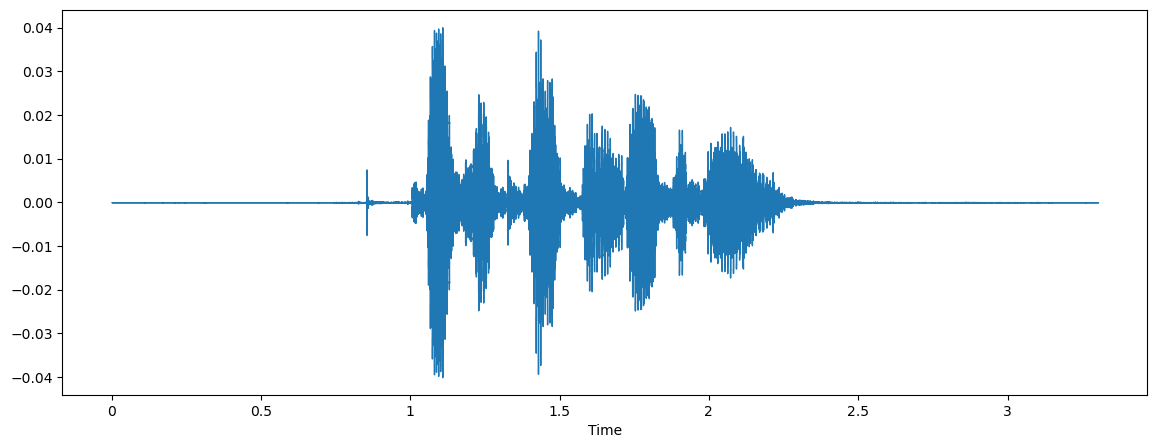

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
# plotting the sampled signal
librosa.display.waveshow(x, sr=sr)

### Trimming the file<a id='Trimming_the_file'></a>

In [57]:
# Define a function to load and trim audio
def load_and_trim_audio(file_path, top_db=30):
    # Load audio file
    y, sr = librosa.load(file_path)
    # Trim silence
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

In [72]:
X_trimmed = load_and_trim_audio(audio_data, top_db=30)

ipd.Audio(X_trimmed, rate=sr)

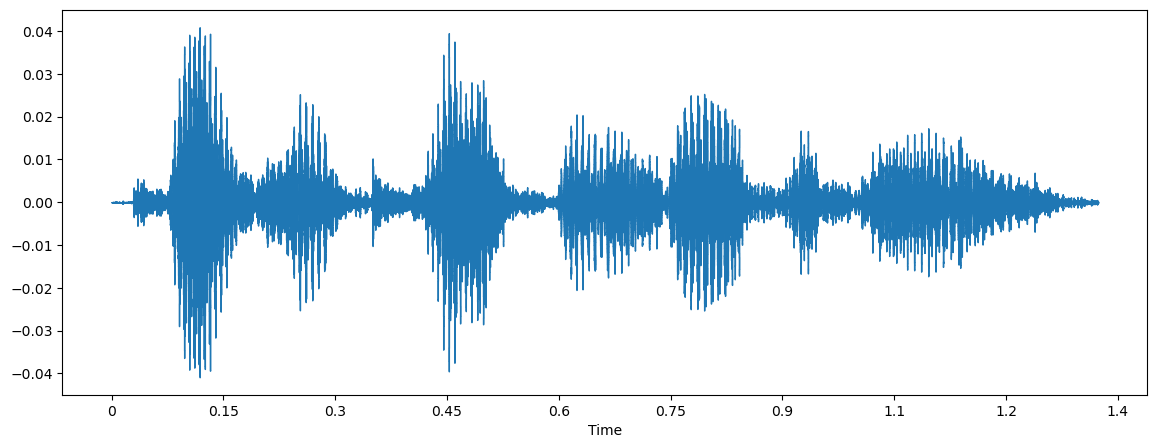

In [73]:
plt.figure(figsize=(14, 5))
# plotting the sampled signal
librosa.display.waveshow(X_trimmed, sr=sr)

### Spectrogram

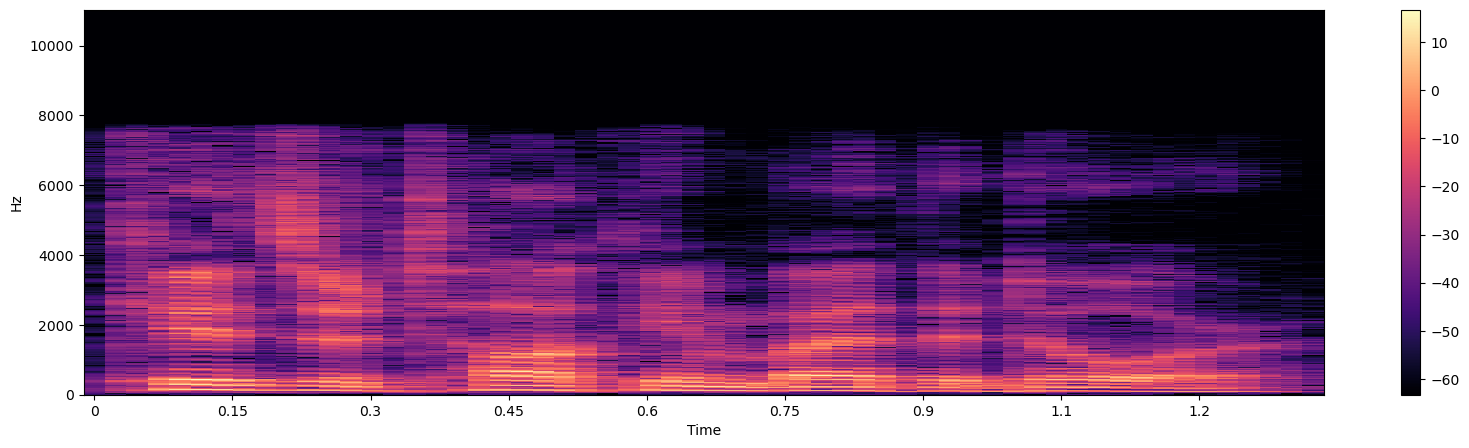

In [61]:
# x: numpy array
X = librosa.stft(X_trimmed)
# converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Display in log-frequency<a id='Display_in_log-frequency'></a>

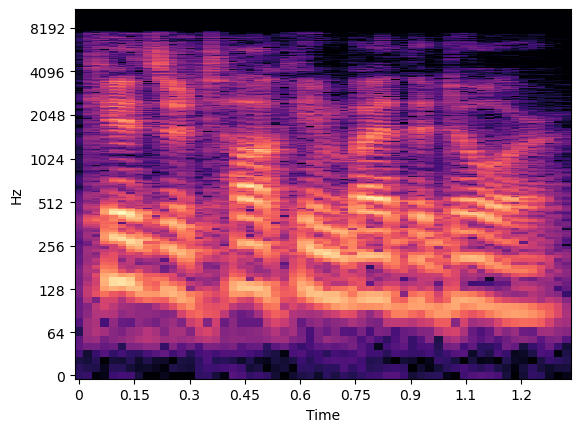

In [62]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')

### Down Sampling Test<a id='Down_Sampling_Test'></a>

In [64]:
# If you need to downsample the audio
desired_sr = 10000  # For example, to downsample to 1 kHz
x_downsampled = librosa.resample(X_trimmed, orig_sr=sr, target_sr=desired_sr)

In [65]:
ipd.Audio(x_downsampled, rate=desired_sr) # play downsampled file

### MFCC, Chroma, Mel Test<a id='MFCC,_Chroma,_Mel_Test'></a>

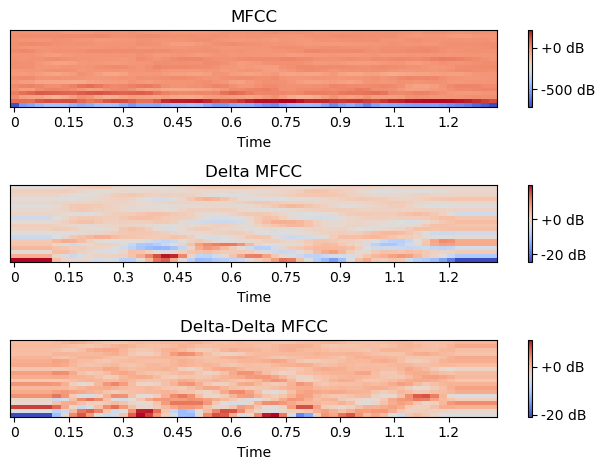

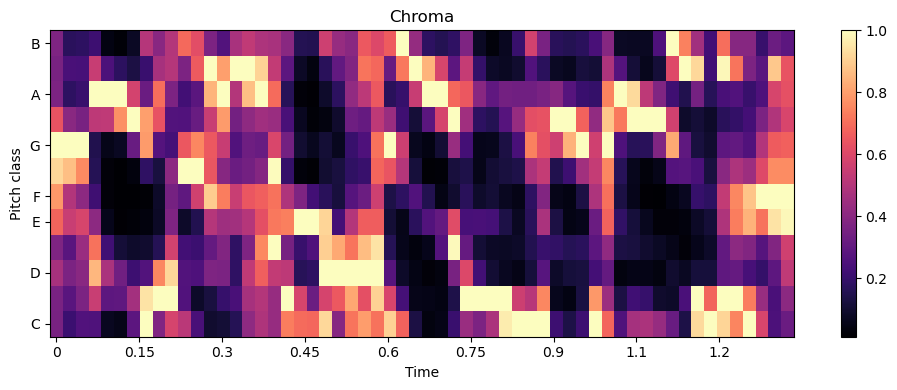

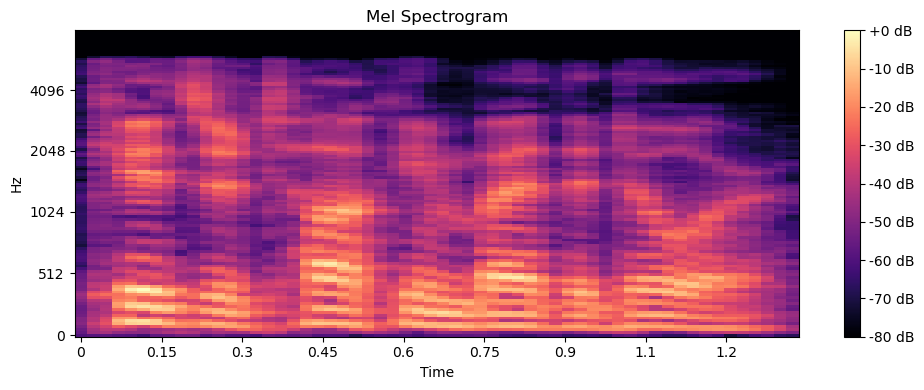

In [77]:
# Load the audio file
# audio_path = f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'
# y, sr = librosa.load(audio_path)

# Extract MFCC
mfcc = librosa.feature.mfcc(y=X_trimmed, sr=sr, n_mfcc=20)
delta_mfccs = librosa.feature.delta(mfcc)
delta2_mfccs = librosa.feature.delta(mfcc, order=2)

# Plot original MFCC
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')

# Plot Delta MFCC
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
librosa.display.specshow(delta_mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta MFCC')

# Plot Delta-Delta MFCC
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
librosa.display.specshow(delta2_mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta-Delta MFCC')

plt.tight_layout()  # Adjust layout

# Extract Chroma
chroma = librosa.feature.chroma_stft(y=X_trimmed, sr=sr)
# Display Chroma
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

# Extract Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=X_trimmed, sr=sr)
# Display Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

## Creating a dataframe<a id='Creating_a_dataframe'></a>

In [51]:
# Define the determine_modality function
def determine_modality(filename):
    try:
        number = int(filename.split('-')[0].rstrip('.wav'))
        if number % 3 == 1:
            return 1
        elif number % 3 == 2:
            return 2
        else:
            return 3
    except Exception as e:
        # print(f"Error in determine_modality: {e}")
        return 'Unknown'

# Define the determine_voice_channel function
def determine_voice_channel(filename):
    try:
        number = int(filename.split('-')[1].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_voice_channel: {e}")
        return 'Unknown'


# Define the dertermine_emotion function
def determine_emotion(filename):
    try:
        number = int(filename.split('-')[2].rstrip('.wav'))
        if number % 8 == 1:
            return 1
        elif number % 8 == 2:
            return 2
        elif number % 8 == 3:
            return 3
        elif number % 8 == 4:
            return 4
        elif number % 8 == 5:
            return 5
        elif number % 8 == 6:
            return 6
        elif number % 8 == 7:
            return 7
        else:
            return 8
    except Exception as e:
        # print(f"Error in determine_emotion: {e}")
        return 'Unknown'


# Define the determine_intensity function
def determine_intensity(filename):
    try:
        number = int(filename.split('-')[3].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_intensity: {e}")
        return 'Unknown'

# Define the determine_statement function
def determine_statement(filename):
    try:
        number = int(filename.split('-')[4].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_statement: {e}")
        return 'Unknown'

# Define the determine_repetition function
def determine_repetition(filename):
    try:
        number = int(filename.split('-')[5].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_repetition: {e}")
        return 'Unknown'
    
# Define the determine_gender function
def determine_gender(filename):
    try:
        number = int(filename.split('-')[6].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_gender: {e}")
        return 'Unknown'

file_pattern = f'{sound_path}/ravdess-data/Actor_*/*.wav'

# Empty list to collect feature data
data = []

# For loop to iterate over files
for file_path in glob.glob(file_pattern):
    try:
        # Extract just the .wav file name
        filename = os.path.basename(file_path)
        
        # Load each individual file
        y = load_and_trim_audio(file_path)

        # Extract features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        delta_mfccs = librosa.feature.delta(mfcc)
        delta2_mfccs = librosa.feature.delta(mfcc, order=2)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

        # Store the mean, max, min, and median of each feature and the gender in the DataFrame
        features = {
            'filename': filename,
            'modality': determine_modality(filename),
            'vocal_channel': determine_voice_channel(filename),
            'emotion': determine_emotion(filename),
            'voice_intensity': determine_intensity(filename),
            'statement': determine_statement(filename),
            'statement_repetition': determine_repetition(filename),
            'actor_gender': determine_gender(filename),
            'mfcc_mean': mfcc.mean(axis=1).mean(),
            'mfcc_max': mfcc.max(axis=1).mean(),
            'mfcc_min': mfcc.min(axis=1).mean(),
            'mfcc_median': np.median(mfcc, axis=1).mean(),
            'mfcc_std': np.std(mfcc, axis=1).mean(),
            'mfcc_delta_mean': delta_mfccs.mean(axis=1).mean(),
            'mfcc_delta_max': delta_mfccs.max(axis=1).mean(),
            'mfcc_delta_min': delta_mfccs.min(axis=1).mean(),
            'mfcc_delta_median': np.median(delta_mfccs, axis=1).mean(),
            'mfcc_delta_std': np.std(delta_mfccs, axis=1).mean(),
            'mfcc_delta_skew': scipy.stats.skew(delta_mfccs, axis=1).mean(),
            'mfcc_delta_kurtosis': scipy.stats.kurtosis(delta_mfccs, axis=1).mean(),
            'mfcc_delta2_mean': delta2_mfccs.mean(axis=1).mean(),
            'mfcc_delta2_max': delta2_mfccs.max(axis=1).mean(),
            'mfcc_delta2_min': delta2_mfccs.min(axis=1).mean(),
            'mfcc_delta2_median': np.median(delta2_mfccs, axis=1).mean(),
            'mfcc_delta2_std': np.std(delta2_mfccs, axis=1).mean(),
            'mfcc_delta2_skew': scipy.stats.skew(delta2_mfccs, axis=1).mean(),
            'mfcc_delta2_kurtosis': scipy.stats.kurtosis(delta2_mfccs, axis=1).mean(),
            'chroma_mean': chroma.mean(axis=1).mean(),
            'chroma_min': chroma.min(axis=1).mean(),
            'chroma_median': np.median(chroma, axis=1).mean(),
            'mel_mean': mel_spectrogram.mean(axis=1).mean(),
            'mel_max': mel_spectrogram.max(axis=1).mean(),
            'mel_min': mel_spectrogram.min(axis=1).mean(),
            'mel_median': np.median(mel_spectrogram, axis=1).mean()
        }

        data.append(features)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())


                   filename  modality  vocal_channel  emotion  \
0  03-01-01-01-01-01-01.wav         3              1        1   
1  03-01-01-01-01-02-01.wav         3              1        1   
2  03-01-01-01-02-01-01.wav         3              1        1   
3  03-01-01-01-02-02-01.wav         3              1        1   
4  03-01-02-01-01-01-01.wav         3              1        2   

   voice_intensity  statement  statement_repetition  actor_gender  mfcc_mean  \
0                1          1                     1             1 -22.325869   
1                1          1                     2             1 -22.428135   
2                1          2                     1             1 -21.613903   
3                1          2                     2             1 -21.395086   
4                1          1                     1             1 -24.031246   

    mfcc_max  ...  mfcc_delta2_std  mfcc_delta2_skew  mfcc_delta2_kurtosis  \
0   9.578151  ...         2.190598          0.0204

## Exploring the dataframe<a id='Exploring_the_dataframe'></a>

### Strong vs normal emotion<a id='Strong_vs_normal_emotion'></a>

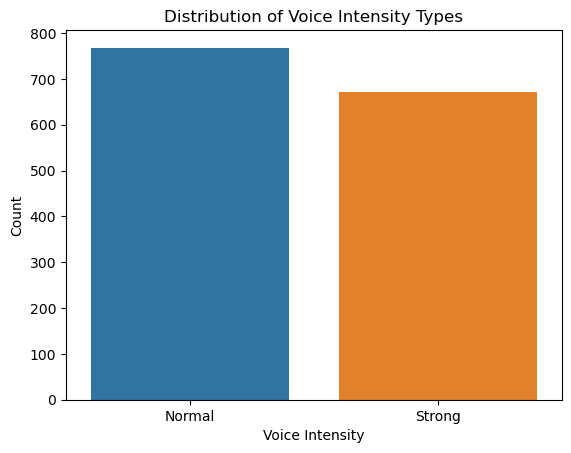

In [30]:
# Replace 1 and 2 with 'Normal' and 'Strong' in the 'voice_intensity' column
# df['voice_intensity'] = df['voice_intensity'].replace({1: 'Normal', 2: 'Strong'})

# Create a count plot
sns.countplot(x='voice_intensity', data=df)

# Adding labels and title for clarity
plt.xlabel('Voice Intensity')
plt.ylabel('Count')
plt.title('Distribution of Voice Intensity Types')
plt.xticks([0, 1], ['Normal', 'Strong'])

# Display the plot
plt.show()

### Number of repeated phrases<a id='Number_of_repeated_phrases'></a>

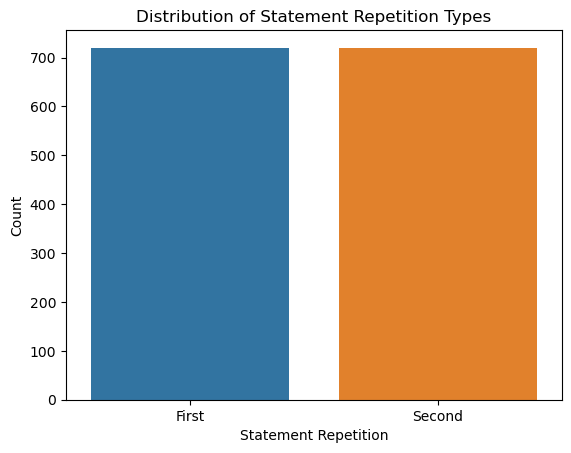

In [31]:
# Replace 1 and 2 with 'First' and 'Second' in the 'statement_repetition' column
# df['statement_repetition'] = df['statement_repetition'].replace({1: 'First', 2: 'Second'})

# Create a count plot
sns.countplot(x='statement_repetition', data=df)

# Adding labels and title for clarity
plt.xlabel('Statement Repetition')
plt.ylabel('Count')
plt.title('Distribution of Statement Repetition Types')
plt.xticks([0, 1], ['First', 'Second'])

# Display the plot
plt.show()


### Number of Male vs Female actors<a id='Number_of_Male_vs_Female_actors'></a>

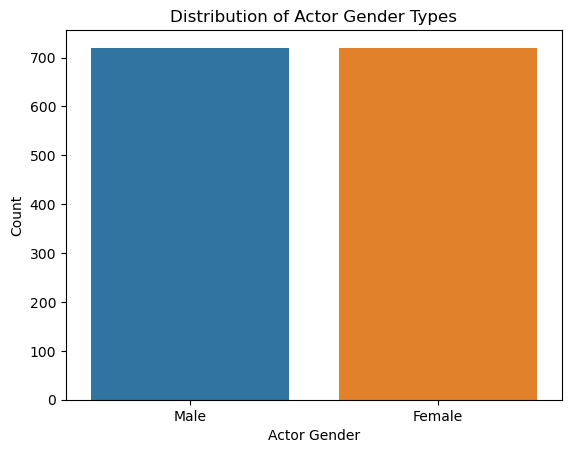

In [32]:
# Replace 1 and 2 with 'Male' and 'Female' in the 'actor_gender' column
# df['actor_gender'] = df['actor_gender'].replace({1: 'Male', 2: 'Female'})

# Create a count plot
sns.countplot(x='actor_gender', data=df)

# Adding labels and title for clarity
plt.xlabel('Actor Gender')
plt.ylabel('Count')
plt.title('Distribution of Actor Gender Types')
plt.xticks([0, 1], ['Male', 'Female'])

# Display the plot
plt.show()

### Distributions Of Feature Values<a id='Distributions_Of_Feature_Values'></a>

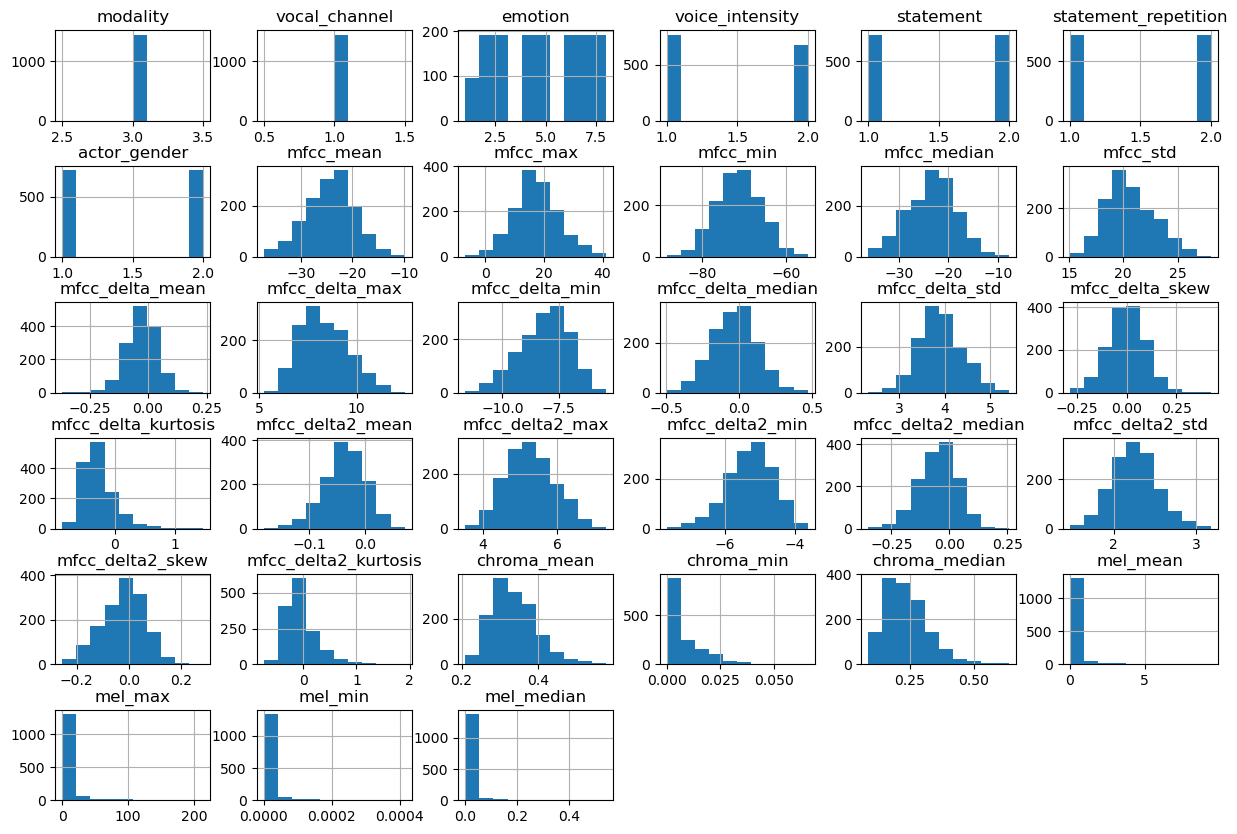

In [52]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

### Numeric data summary<a id='Numeric_data_summary'></a>

In [53]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
modality,1440.0,3.000000,0.000000,3.000000,3.000000e+00,3.000000,3.000000,3.000000
vocal_channel,1440.0,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
emotion,1440.0,4.733333,2.175356,1.000000,3.000000e+00,5.000000,7.000000,8.000000
voice_intensity,1440.0,1.466667,0.499061,1.000000,1.000000e+00,1.000000,2.000000,2.000000
statement,1440.0,1.500000,0.500174,1.000000,1.000000e+00,1.500000,2.000000,2.000000
statement_repetition,1440.0,1.500000,0.500174,1.000000,1.000000e+00,1.500000,2.000000,2.000000
actor_gender,1440.0,1.500000,0.500174,1.000000,1.000000e+00,1.500000,2.000000,2.000000
mfcc_mean,1440.0,-24.240213,4.677576,-37.155903,-2.751264e+01,-23.896271,-21.161583,-9.845119
mfcc_max,1440.0,17.297712,7.731437,-6.892805,1.243164e+01,16.860287,22.119385,41.245110
mfcc_min,1440.0,-71.286140,5.408780,-88.499496,-7.498808e+01,-71.340038,-67.612108,-54.771202


### Checking for missing values<a id='Checking_for_missing_values'></a>

In [54]:
df.isna().count()

filename                1440
modality                1440
vocal_channel           1440
emotion                 1440
voice_intensity         1440
statement               1440
statement_repetition    1440
actor_gender            1440
mfcc_mean               1440
mfcc_max                1440
mfcc_min                1440
mfcc_median             1440
mfcc_std                1440
mfcc_delta_mean         1440
mfcc_delta_max          1440
mfcc_delta_min          1440
mfcc_delta_median       1440
mfcc_delta_std          1440
mfcc_delta_skew         1440
mfcc_delta_kurtosis     1440
mfcc_delta2_mean        1440
mfcc_delta2_max         1440
mfcc_delta2_min         1440
mfcc_delta2_median      1440
mfcc_delta2_std         1440
mfcc_delta2_skew        1440
mfcc_delta2_kurtosis    1440
chroma_mean             1440
chroma_min              1440
chroma_median           1440
mel_mean                1440
mel_max                 1440
mel_min                 1440
mel_median              1440
dtype: int64

## Exporting DataFrame<a id='Exporting_DataFrame'></a>

In [56]:
# Exporting to CSV file
df.to_csv('voice_data_dw.csv', index=False)

## Summary

The tests were successful and I was able to successfully import the files into a dataframe.  With a little examination 
of the features I was able to extract we can see an even number of male versus female actors. Same goes fort the repetition
of statements but the intensity was sqewed but that is understandable since the 'neutral' emotion does not have a 'strong'
intensity so there are less of them. I decided not to downsample the audio files upon further research. 16000 Hz seems to be 
the minimum standard for voice data and I'd prefer not to compromise the later model's ability to accurately predict 
emotions because of a reduction in quality. Next step is Exploratory Data Analysis and I'm excited to see what patterns arise.